In [1]:
#pip install --upgrade pip

In [2]:
#pip install opencv-python

In [3]:
#import sys
#{sys.executable} -m pip install scikit-learn


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image

# Keras imports
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.constraints import MaxNorm
from keras.utils import to_categorical
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# TensorFlow Keras imports
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50
#from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# Other imports
import seaborn as sns

#from sklearn.metrics import confusion_matrix, classification_report


2024-06-16 17:30:17.385294: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
import os
import cv2
from collections import Counter

# Function to generate and save augmented images while maintaining class balance
def generate_and_save_augmented_images(generator, save_dir, target_total):
    class_counts = Counter(generator.classes)
    max_count = max(class_counts.values())

    # Calculate the number of augmented images needed for each class
    augmented_images_needed = {cls: target_total - count for cls, count in class_counts.items()}

    # Create the augmented dataset directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Create class-specific directories within the save_dir
    for cls in class_counts.keys():
        class_dir = os.path.join(save_dir, f'class_{cls}')
        os.makedirs(class_dir, exist_ok=True)

    total_generated = {cls: 0 for cls in class_counts.keys()}

    while any(total_generated[cls] < augmented_images_needed[cls] for cls in class_counts.keys()):
        # Generate a batch of images and labels
        images, labels = next(generator)
        
        for img, label in zip(images, labels):
            cls = int(label)
            if total_generated[cls] < augmented_images_needed[cls]:
                total_generated[cls] += 1
                save_path = os.path.join(save_dir, f'class_{cls}', f'class_{cls}_augmented_{total_generated[cls]}.png')
                img = (img * 255).astype('uint8')  # Convert back to uint8
                img = img[..., ::-1]  # Convert RGB to BGR for saving with OpenCV
                cv2.imwrite(save_path, img)
                
            if all(total_generated[cls] >= augmented_images_needed[cls] for cls in class_counts.keys()):
                break

    print(f"Total augmented images generated and saved: {sum(total_generated.values())}")

    return save_dir

In [6]:
dataset_dir = 'dataset'

In [7]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Function to count the number of images in each class
def count_images_per_class(dataset_path):
    class_counts = {}
    for class_dir in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_dir)
        if os.path.isdir(class_path):
            class_counts[class_dir] = len(os.listdir(class_path))
    return class_counts




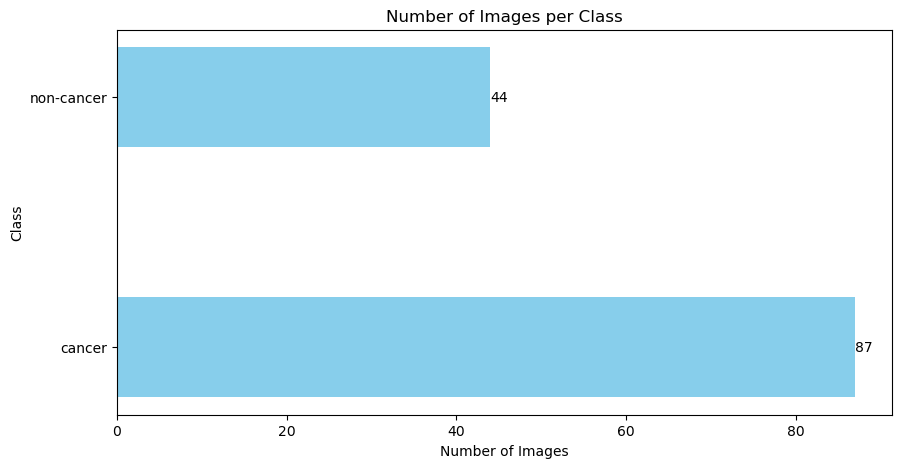

In [8]:
# Path to dataset
dataset_path = 'dataset'          # Replace with the actual path to your dataset
# Count images in each class
class_counts = count_images_per_class(dataset_path)

# Plot the number of images in each class using a horizontal bar chart
def plot_class_distribution(class_counts):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 5))
    bars = plt.barh(classes, counts, color='skyblue', height=0.4)  # Adjust the height of the bars
    plt.xlabel('Number of Images')
    plt.ylabel('Class')
    plt.title('Number of Images per Class')

    # Add number of images on top of each bar
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                 f'{int(bar.get_width())}', va='center', ha='left')

    plt.show()

# Plot the class distribution
plot_class_distribution(class_counts)

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,                 # Rescale pixel values to [0, 1]
    rotation_range=10,                # Randomly rotate images up to 10 degrees
    fill_mode='nearest',              # Fill newly created pixels with nearest existing pixel value
    featurewise_center=True,          # Subtract mean of dataset from each sample
    featurewise_std_normalization=True,  # Divide each sample by the standard deviation of the dataset
    vertical_flip=True,               # Randomly flip images vertically
    shear_range=0.2,                  # Randomly apply shearing transformations
    zoom_range=0.2,                   # Randomly apply zooming transformations
    brightness_range=(0.4, 0.6),      # Randomly adjust brightness of images
    horizontal_flip=True,             # Randomly flip images horizontally
    validation_split=0.3              # Fraction of data to reserve for validation
)

In [10]:
train_generator = train_datagen.flow_from_directory(
  dataset_dir,
  target_size=(224, 224),
  batch_size=32,
  class_mode='binary',subset='training'
  )


Found 92 images belonging to 2 classes.


In [11]:
validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',subset='validation'

  )


Found 39 images belonging to 2 classes.


In [12]:

# Set the target number of images for each class
target_total = 420  # Adjust as needed

# Directory to save the augmented images for training
train_augmented_dir = f'augmented_training_{os.path.basename(dataset_dir)}'
train_augmented_dir = generate_and_save_augmented_images(train_generator, train_augmented_dir, target_total)

target_total1 = 250  # Adjust as needed
# Directory to save the augmented images for validation
validation_augmented_dir = f'augmented_validation_{os.path.basename(dataset_dir)}'
validation_augmented_dir = generate_and_save_augmented_images(validation_generator, validation_augmented_dir, target_total1)


/Users/gurnoorchhabra/opt/anaconda3/lib/python3.9/site-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/Users/gurnoorchhabra/opt/anaconda3/lib/python3.9/site-packages/keras/src/legacy/preprocessing/image.py:1273: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/Users/gurnoorchhabra/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Total augmented images generated and saved: 748
Total augmented images generated and saved: 461


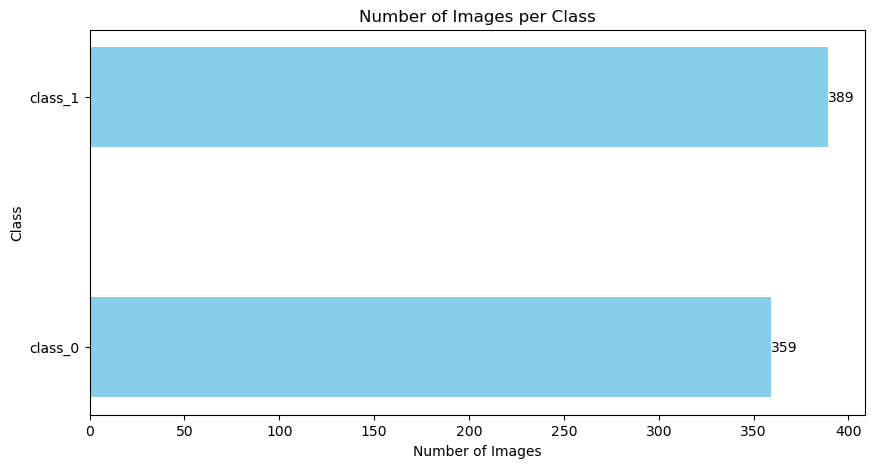

In [13]:
# Count images in each class
class_counts = count_images_per_class(train_augmented_dir )

# Plot the number of images in each class using a horizontal bar chart
def plot_class_distribution(class_counts):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 5))
    bars = plt.barh(classes, counts, color='skyblue', height=0.4)  # Adjust the height of the bars
    plt.xlabel('Number of Images')
    plt.ylabel('Class')
    plt.title('Number of Images per Class')

    # Add number of images on top of each bar
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                 f'{int(bar.get_width())}', va='center', ha='left')

    plt.show()

# Plot the class distribution
plot_class_distribution(class_counts)

In [14]:
test_generator = train_datagen.flow_from_directory(
     "augmented_training_dataset",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
subset='validation'
  )


Found 223 images belonging to 2 classes.


In [15]:
train_generator = train_datagen.flow_from_directory(
  "augmented_training_dataset",
  target_size=(224, 224),
  batch_size=32,
  class_mode='binary',subset='training'
  )


Found 525 images belonging to 2 classes.


In [16]:
validation_generator = train_datagen.flow_from_directory(
    "augmented_training_dataset",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',subset='validation'

  )


Found 223 images belonging to 2 classes.


In [17]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def fine_tuned_VGG19(input_shape=(224, 224, 3), num_classes=1):
    # Load pre-trained VGG19 model without including top layers
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification layers on top of the base model
    x = Flatten()(base_model.output)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)  # Add dropout to reduce overfitting
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)  # Add dropout to reduce overfitting
    output = Dense(num_classes, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create the fine-tuned VGG19 model
model = fine_tuned_VGG19(input_shape=(224, 224, 3), num_classes=1)

# Display model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             

 Total params: 139,574,337 (532.43 MB)

 Trainable params: 119,549,953 (456.05 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [18]:
# Initial training with frozen layers
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [19]:


# Fit the model using the current training generator
FIT = model.fit(
    train_generator,
    validation_data=validation_generator,
    callbacks=[checkpoint,early_stop],
    epochs=50
)


/Users/gurnoorchhabra/opt/anaconda3/lib/python3.9/site-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/Users/gurnoorchhabra/opt/anaconda3/lib/python3.9/site-packages/keras/src/legacy/preprocessing/image.py:1273: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/50


/Users/gurnoorchhabra/opt/anaconda3/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 108s 6s/step - accuracy: 0.4837 - loss: 1.2083 - val_accuracy: 0.5426 - val_loss: 0.6918
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 100s 6s/step - accuracy: 0.5768 - loss: 0.8850 - val_accuracy: 0.4798 - val_loss: 1.1674
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 99s 6s/step - accuracy: 0.5400 - loss: 0.8926 - val_accuracy: 0.5650 - val_loss: 0.7927
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 104s 6s/step - accuracy: 0.5832 - loss: 0.8408 - val_accuracy: 0.6592 - val_loss: 0.6078
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 106s 6s/step - accuracy: 0.6235 - loss: 0.6850 - val_accuracy: 0.7713 - val_loss: 0.5383
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 102s 6s/step - accuracy: 0.6581 - loss: 0.6360 - val_accuracy: 0.6009 - val_loss: 0.6674
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 102s 6s/step - accuracy: 0.6514 - loss: 0.6671 - val_accuracy: 0.7085 - val_loss: 0.5451
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 111s 6s/step - accuracy: 0.7202 - loss: 0.5420 - val_accuracy: 0.8027 - val_loss: 0.4

In [20]:
# Unfreeze some top layers of the base model for fine-tuning
for layer in model.layers[-8:]:
    if not isinstance(layer, Dense):
        layer.trainable = True

In [21]:
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

The **EarlyStopping callback** in TensorFlow/Keras is a useful tool for preventing **overfitting** during training by monitoring a specified metric (e.g., **validation loss**) and stopping training early if the metric stops improving.

**monitor:** This specifies the quantity to be monitored during training. In this case, 'val_loss' indicates that the callback will monitor the ***validation loss***.

**patience**: This parameter determines the number of epochs with no improvement after which training will be stopped. If the validation loss doesn't improve for patience number of epochs, training will stop. In this case, patience=5 means training will stop if the validation loss doesn't improve for 5 consecutive epochs.

**restore_best_weights**: When set to True, this parameter restores the model weights from the epoch with the best value of the monitored quantity. This ensures that the model used for inference after early stopping has the best performance on the validation set.

In [22]:
# Continue training with unfrozen layers
history_fine_tune = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 106s 6s/step - accuracy: 0.5847 - loss: 5.3462 - val_accuracy: 0.4843 - val_loss: 1.0343
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 102s 6s/step - accuracy: 0.5805 - loss: 0.7192 - val_accuracy: 0.6771 - val_loss: 0.5689
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 102s 6s/step - accuracy: 0.7211 - loss: 0.5234 - val_accuracy: 0.7130 - val_loss: 0.5663
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 106s 6s/step - accuracy: 0.7724 - loss: 0.4740 - val_accuracy: 0.8565 - val_loss: 0.3601
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 103s 6s/step - accuracy: 0.8235 - loss: 0.3631 - val_accuracy: 0.8386 - val_loss: 0.3810
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 104s 6s/step - accuracy: 0.8899 - loss: 0.3024 - val_accuracy: 0.8072 - val_loss: 0.4376
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 100s 6s/step - accuracy: 0.8596 - loss: 0.3143 - val_accuracy: 0.8879 - val_loss: 0.2626
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 101s 6s/step - accuracy: 0.9035 - loss: 0.3232 - val_accuracy: 0.9417 - v

In [23]:
model.evaluate(test_generator)

7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8950 - loss: 0.2002


[0.15977033972740173, 0.9237667918205261]

In [24]:
#classes names
class_name = {0:"Cancer",1:"non cancer"}

In [25]:
# Initialize arrays to hold true and predicted labels
y_true = np.array([])
y_pred = np.array([])

# Iterate through the test generator
for data, labels in test_generator:
    # Predict probabilities for the current batch
    y_prob = model.predict(data)
    
    # Convert probabilities to binary predictions
    y_binary = (y_prob > 0.5).astype(int).flatten()
    
    # Append true labels and predicted labels to the arrays
    y_true = np.append(y_true, labels)
    y_pred = np.append(y_pred, y_binary)
    
    # Break the loop after going through all samples
    if len(y_true) >= test_generator.samples:
        break

# Output the true and predicted labels
y_true, y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


(array([0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
        1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1.,
        1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
        0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
        1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
        1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
        1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
        1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
        0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1.,
        0., 

In [29]:
pip install pandas seaborn matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


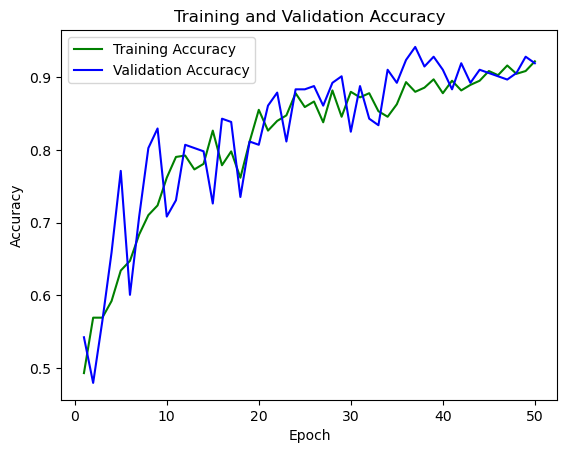

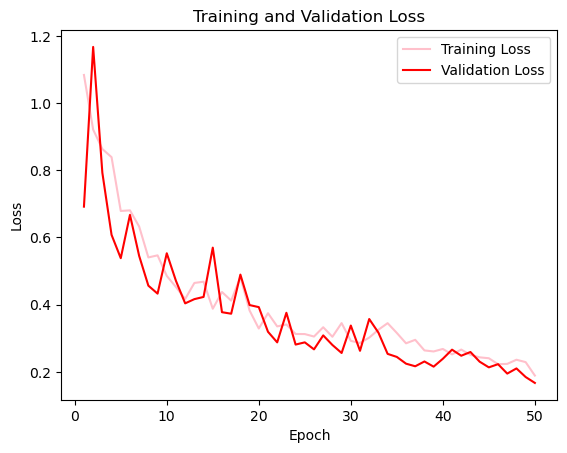

In [31]:
#plot the result
import matplotlib.pyplot as plt
acc = FIT.history['accuracy']
val_acc = FIT.history['val_accuracy']
loss = FIT.history['loss']
val_loss = FIT.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [32]:
model.save('oral cancer-vggg19.h5')